# **User Activity-Based Day Quality Model**

This model helps you understand how your daily activities impact the overall quality of your day. By analyzing your activities and the corresponding moods throughout the day, it classifies the day's quality into categories such as terrible, bad, okay, good, or excellent.

## **Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

* **TensorFlow and Keras**: These are tools for building and training deep learning models. TensorFlow is like the main engine, and Keras is a special tool within TensorFlow that makes it easier to create these models.

* **Scikit-Learn**: This tool helps with getting data ready for learning and splitting it into parts for testing. It does things like changing labels into numbers and dividing up the data for testing.

* **Pandas**: This tool is for working with data in a neat and organized way. It's like a list that helps keep data tidy and easy to work with.

* **NumPy**: NumPy helps with doing math on data. It's good at working with numbers arranged in lists or grids and has lots of math tricks.

* **Seaborn and Matplotlib**: These tools help visualize data. They make it easier to see patterns and relationships in the data by creating pictures.

## **Dataset**

This dataset came from a survey we conducted with our friends and has already been sorted and evaluated manually by us.

In [ ]:
df=pd.read_excel('MOOD TRAK.xlsx')
df.head()

,Time Stamp,Day,Activities,Start,End,Quality,Note
0,2024-05-01 07:00:00,Wednesday,sleep,23:00:00,05:00:00,okay,Bangun pagi untuk sholat subuh.
1,2024-05-01 07:00:00,Wednesday,selfcare,05:00:00,05:30:00,good,"Mandi dan bersiap, air dingin di pagi hari tid..."
2,2024-05-01 07:00:00,Wednesday,eating,05:30:00,06:00:00,good,Sarapan pagi dengan roti bakar dan susu.
3,2024-05-01 07:00:00,Wednesday,workout,06:00:00,07:00:00,excellent,Jogging sekitar kos-kosan. Bertemu banyak anak...
4,2024-05-01 07:00:00,Wednesday,traveling,07:00:00,07:30:00,excellent,"Berangkat ke kampus, perjalanan sekitar 2 km d..."


1. **Time Stamp**: This tells when the activity happened.

2. **Day**: Shows which day of the week it was.

3. **Activities**: Describes what was done, like sleeping or eating.

4. **Start**: Says when the activity began.

5. **End**: Tells when the activity finished.

6. **Quality**: Rates how good the activity was, like okay or excellent.

7. **Note**: Gives extra details or thoughts about the activity.

##**Data Preprocessing**

###**Fixing Columns and Format**

In [ ]:
df_new=df.drop(columns=['Note','Start','End'])
# Convert time columns to datetime
df_new['Time Stamp'] = pd.to_datetime(df_new['Time Stamp']).dt.date
# Map quality ratings to numeric values
quality_mapping = {'terrible': 1, 'bad': 2, 'okay': 3, 'good': 4, 'excellent': 5}
df_new['Quality'] = df_new['Quality'].map(quality_mapping)

df_new['Week'] = pd.to_datetime(df_new['Time Stamp']).dt.isocalendar().week
df_new['Year'] = pd.to_datetime(df_new['Time Stamp']).dt.isocalendar().year

# Create a unique identifier for each day
df_new['Date_Index'] =df_new['Year'].astype(str) + '-' + df_new['Week'].astype(str) + '-' + df_new['Day']
df_new=df_new.drop(columns=['Day','Time Stamp','Week','Year'])

df_new

,Activities,Quality,Date_Index
0,sleep,3,2024-18-Wednesday
1,selfcare,4,2024-18-Wednesday
2,eating,4,2024-18-Wednesday
3,workout,5,2024-18-Wednesday
4,traveling,5,2024-18-Wednesday
...,...,...,...
1215,entertainment,3,2024-32-Tuesday
1216,eating,3,2024-32-Tuesday
1217,study,3,2024-32-Tuesday
1218,dating,3,2024-32-Tuesday


### **Data Generate**

Because the dataset from survey is limited (1220 rows) and for classification model need **SO MUCH** data, so we generate data using functions. This function generate data based on activity and quality of the activity also with unique date index (20 Year Generated Data).

In [ ]:
# List of Activities
activities = [
    "sleep", "selfcare", "eating", "workout", "traveling", "study",
    "entertainment", "dating","work"
]

# List of days in week
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Function to generate data
def generate_data(num_entries):
    data = {
        "Activities": np.random.choice(activities, num_entries),
        "Quality": np.random.randint(1, 6, num_entries),
        "Date_Index": [f"{np.random.randint(2004,2024)}-{np.random.randint(1, 54)}-{day}" for day in np.random.choice(weekdays, num_entries)]
    }
    return pd.DataFrame(data)


num_entries = 20000
df_generate = generate_data(num_entries)
updated_df = pd.concat([df_new, df_generate], ignore_index=True)

In [ ]:
updated_df

,Activities,Quality,Date_Index
0,sleep,3,2024-18-Wednesday
1,selfcare,4,2024-18-Wednesday
2,eating,4,2024-18-Wednesday
3,workout,5,2024-18-Wednesday
4,traveling,5,2024-18-Wednesday
...,...,...,...
21215,traveling,3,2023-24-Thursday
21216,sleep,3,2015-32-Wednesday
21217,study,3,2017-25-Saturday
21218,eating,5,2023-19-Monday


### **Overall Quality Calculation for Each Day**

Creating this function helps measure how good or bad a day is by looking at all the different things we do. Each activity we do has a weight, showing how important it is. By combining these weights with how we rate each activity, we get an overall score for the day. This score gives a clear picture of the day’s quality based on all our activities.

### **1. Define Activity Weights**
Each activity is assigned a weight reflecting its daily impact on mood and well-being:

- **Sleep**: 0.2 - Directly affects energy levels and overall mood.
- **Study**: 0.1 - Important for personal growth but less immediate in mood impact.
- **Work**: 0.35 - Significantly influences stress levels and satisfaction.
- **Dating**: 0.05 - Emotional well-being factor, with variable frequency.
- **Selfcare**: 0.05 - Essential for health, with cumulative effects.
- **Traveling**: 0.05 - Can vary in impact based on experience.
- **Entertainment**: 0.1 - Provides relaxation and enjoyment.
- **Eating**: 0.05 - Affects physical health and energy levels.
- **Workout**: 0.05 - Vital for physical and mental well-being.

These weights reflect our belief that certain activities have a stronger influence on our daily mood and overall well-being. By assigning weights based on this understanding, we aim to create a more accurate and personalized measure of daily quality.


### **2. Quality Ratings**
Each activity is rated on a scale from 1 to 5, where:
- 1: Terrible
- 2: Bad
- 3: Okay
- 4: Good
- 5: Excellent

### **3. Overall Daily Quality Score**
To obtain the daily quality score, the sum of the overall qualities for each activity on a day is averaged (if needed, depending on the number of activities):

**Daily Quality Score $=\frac{\Sigma \text { (Quality } \times \text { Activity Weight) }}{\text { Number of Activities }}$**


In [ ]:
# Define weights for each activity (higher weight means higher significance)
activity_weights = {
    'sleep': 0.2,
    'study': 0.1,
    'work': 0.35,
    'dating':0.05,
    'selfcare':0.05,
    'traveling':0.05,
    'entertainment':0.1,
    'eating':0.05,
    'workout':0.05
}
# Calculate overall day quality score for each day
updated_df['Overall_Quality'] = updated_df['Quality'] * updated_df['Activities'].map(activity_weights)
daily_quality = updated_df.groupby(['Date_Index']).agg({'Overall_Quality': 'mean'}).reset_index()

daily_quality

,Date_Index,Overall_Quality
0,2004-1-Friday,0.200000
1,2004-1-Monday,0.340000
2,2004-1-Saturday,0.287500
3,2004-1-Sunday,0.175000
4,2004-1-Thursday,0.175000
...,...,...
6994,2024-31-Thursday,0.346154
6995,2024-31-Tuesday,0.519231
6996,2024-31-Wednesday,0.364286
6997,2024-32-Monday,0.346154


### **Visualize the Distribution**

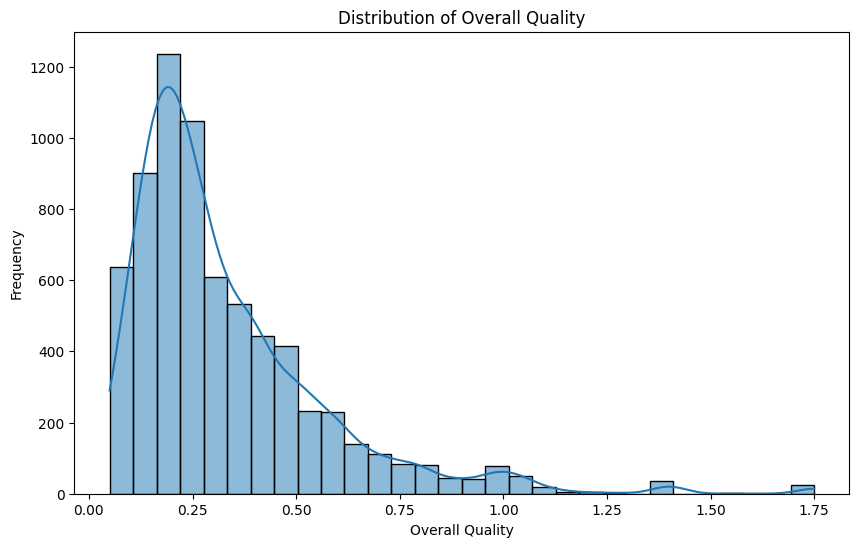

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(daily_quality['Overall_Quality'], bins=30, kde=True)
plt.title('Distribution of Overall Quality')
plt.xlabel('Overall Quality')
plt.ylabel('Frequency')
plt.show()

### **Outlier Cleaning**

In [ ]:
# Menghitung IQR untuk mendeteksi outlier
Q1 = daily_quality['Overall_Quality'].quantile(0.25)
Q3 = daily_quality['Overall_Quality'].quantile(0.75)
IQR = Q3 - Q1

# Menentukan batas bawah dan atas untuk deteksi outlier
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Membersihkan outlier
df_cleaned = daily_quality[(daily_quality['Overall_Quality'] >= lower_bound) & (daily_quality['Overall_Quality'] <= upper_bound)]

In [ ]:
df_cleaned

,Date_Index,Overall_Quality
0,2004-1-Friday,0.200000
1,2004-1-Monday,0.340000
2,2004-1-Saturday,0.287500
3,2004-1-Sunday,0.175000
4,2004-1-Thursday,0.175000
...,...,...
6994,2024-31-Thursday,0.346154
6995,2024-31-Tuesday,0.519231
6996,2024-31-Wednesday,0.364286
6997,2024-32-Monday,0.346154


### **Quantile Calculations**

In [ ]:
# calculate quantiles from 10 to 100
quantiles = df_cleaned['Overall_Quality'].quantile([q/100 for q in range(10, 101, 10)])
quantiles

0.1    0.116667
0.2    0.150000
0.3    0.183333
0.4    0.212500
0.5    0.250000
0.6    0.292308
0.7    0.350000
0.8    0.425000
0.9    0.540000
1.0    0.775000
Name: Overall_Quality, dtype: float64

### **Classify the Data**


To achieve a balanced classification reflecting mental well-being, we propose an alternative approach that divides the data into five categories: Terrible, Bad, Okay, Good, and Excellent. Each category is defined by specific percentile ranges derived from the dataset.

The classification thresholds are as follows:

- **Terrible**: This category represents the lowest 10% of the data, ranging from the **minimum value to the 10th percentile** (0.050 to 0.116667).
- **Bad**: Encompassing the next 20% of the data, this category extends from the **10th percentile to the 30th percentile** (0.116667 to 0.183333).
- **Okay**: Covering the middle 30% of the data, this category spans from the **30th percentile to the 60th percentile** (0.183333 to 0.292308).
- **Good**: Encompassing the next 30% of the data, this category extends from the **60th percentile to the 90th percentile** (0.292308 to 0.540000).
- **Excellent**: This category represents the top 10% of the data, ranging from **the 90th percentile to the maximum value** (0.540000 to 0.775).

In [ ]:
# Define classification thresholds based on the overall day quality score
classification_thresholds = {
    'terrible': 0.116667,
    'bad': 0.183333,
    'okay': 0.292308,
    'good': 0.540000,
    'excellent': 0.775,
}
# Classify each day based on the overall quality score
def classify_day(quality_score):
    for category, threshold in classification_thresholds.items():
        if quality_score < threshold:
            return category
    return 'excellent'  # If quality score exceeds all thresholds, classify as 'excellent'

df_cleaned['Category'] = df_cleaned['Overall_Quality'].apply(classify_day)

df_cleaned

<ipython-input-23-528bb1afa0c3>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Category'] = df_cleaned['Overall_Quality'].apply(classify_day)


,Date_Index,Overall_Quality,Category
0,2004-1-Friday,0.200000,okay
1,2004-1-Monday,0.340000,good
2,2004-1-Saturday,0.287500,okay
3,2004-1-Sunday,0.175000,bad
4,2004-1-Thursday,0.175000,bad
...,...,...,...
6994,2024-31-Thursday,0.346154,good
6995,2024-31-Tuesday,0.519231,good
6996,2024-31-Wednesday,0.364286,good
6997,2024-32-Monday,0.346154,good


### **Visualize the Classification**

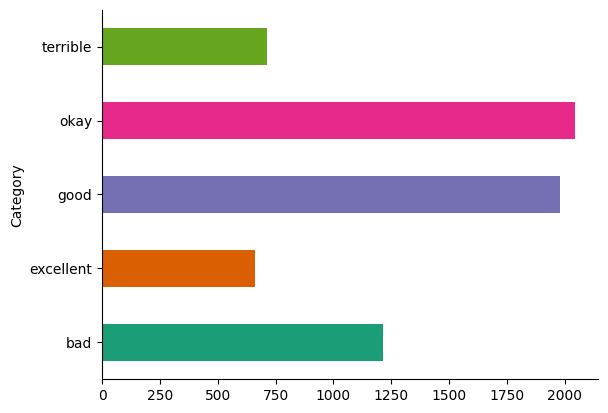

In [ ]:
df_cleaned.groupby('Category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Convert the category from string to integer.

In [ ]:
# Encode 'Day_Condition' column to integers
label_encoder = LabelEncoder()
df_cleaned['Category'] = label_encoder.fit_transform(df_cleaned['Category'])
df_cleaned

<ipython-input-25-5f1bb5a9d14e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Category'] = label_encoder.fit_transform(df_cleaned['Category'])


,Date_Index,Overall_Quality,Category
0,2004-1-Friday,0.200000,3
1,2004-1-Monday,0.340000,2
2,2004-1-Saturday,0.287500,3
3,2004-1-Sunday,0.175000,0
4,2004-1-Thursday,0.175000,0
...,...,...,...
6994,2024-31-Thursday,0.346154,2
6995,2024-31-Tuesday,0.519231,2
6996,2024-31-Wednesday,0.364286,2
6997,2024-32-Monday,0.346154,2


* 0 = bad
* 4 = terrible
* 2 = good
* 3 = okay
* 1 = excellent

## **Data Modelling**

In [ ]:
# Prepare data for model
X = df_cleaned.drop(columns=['Date_Index', 'Category']).values
y = df_cleaned['Category'].values

In [ ]:
# Split data into train and test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split test data into validation and test (50% validation, 50% test)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Check the shapes of the datasets
print("Train set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (5288, 1) (5288,)
Validation set shape: (661, 1) (661,)
Test set shape: (662, 1) (662,)


In [ ]:
# Define the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(1,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')  # 5 classes for 5 categories
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/100
166/166 [==============================] - 2s 4ms/step - loss: 1.4870 - accuracy: 0.3228 - val_loss: 1.3364 - val_accuracy: 0.4054
Epoch 2/100
166/166 [==============================] - 0s 2ms/step - loss: 1.1214 - accuracy: 0.5709 - val_loss: 0.8951 - val_accuracy: 0.6641
Epoch 3/100
166/166 [==============================] - 0s 2ms/step - loss: 0.7308 - accuracy: 0.7719 - val_loss: 0.5985 - val_accuracy: 0.8684
Epoch 4/100
166/166 [==============================] - 0s 2ms/step - loss: 0.5062 - accuracy: 0.8984 - val_loss: 0.4276 - val_accuracy: 0.9289
Epoch 5/100
166/166 [==============================] - 0s 2ms/step - loss: 0.3790 - accuracy: 0.9603 - val_loss: 0.3294 - val_accuracy: 0.9289
Epoch 6/100
166/166 [==============================] - 0s 2ms/step - loss: 0.2993 - accuracy: 0.9760 - val_loss: 0.2661 - val_accuracy: 0.9909
Epoch 7/100
166/166 [==============================] - 0s 2ms/step - loss: 0.2457 - accuracy: 0.9858 - val_loss: 0.2373 - val_accuracy: 0.9274

## **Model Evaluation**

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

21/21 [==============================] - 0s 2ms/step - loss: 0.0258 - accuracy: 0.9894
Test accuracy: 0.9894259572029114


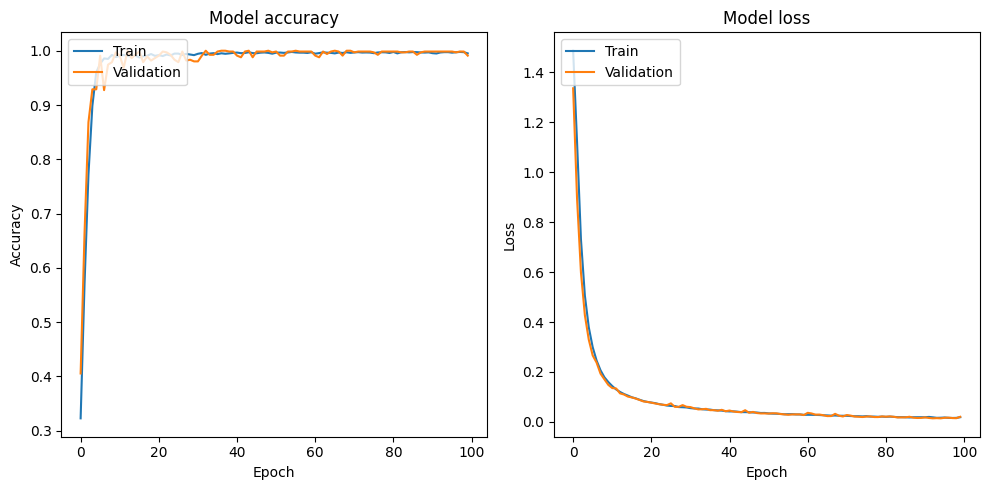

In [ ]:
# Plot training history
plt.figure(figsize=(10, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

## **Model Save**

In [ ]:
model.save('quality_condition_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Convert the Keras model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('model_quality.tflite', 'wb') as f:
    f.write(tflite_model)